Based on this resource [see](https://www.kaggle.com/code/tanmay111999/avocado-price-forecast-arima-sarima-detailed/notebook#Summary-of-EDA)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime

from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
pd.options.display.float_format = '{:.2f}'.format


In [2]:
data = pd.read_csv('Data/avocado.csv')

<Axes: >

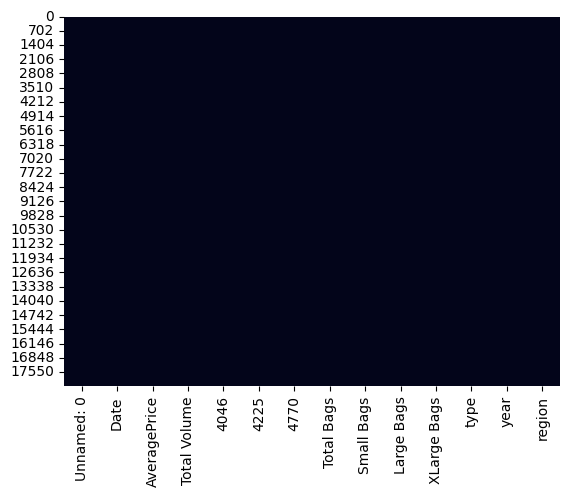

In [3]:
sns.heatmap(data.isnull(), cbar=False)

In [4]:
df = data.copy(deep=True)
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

Takes your time-series DataFrame df.
Resamples the data into weekly intervals.
Calculates the sum of all the values within each week.
Returns a new DataFrame where each row represents a week and the value is the total for that week.

In [5]:
df =df.resample('W').sum()

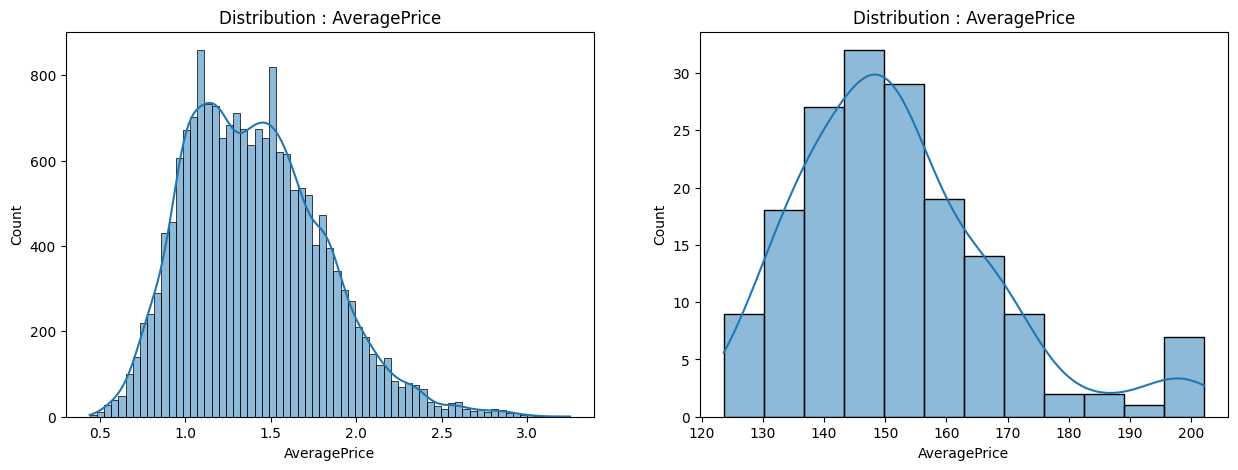

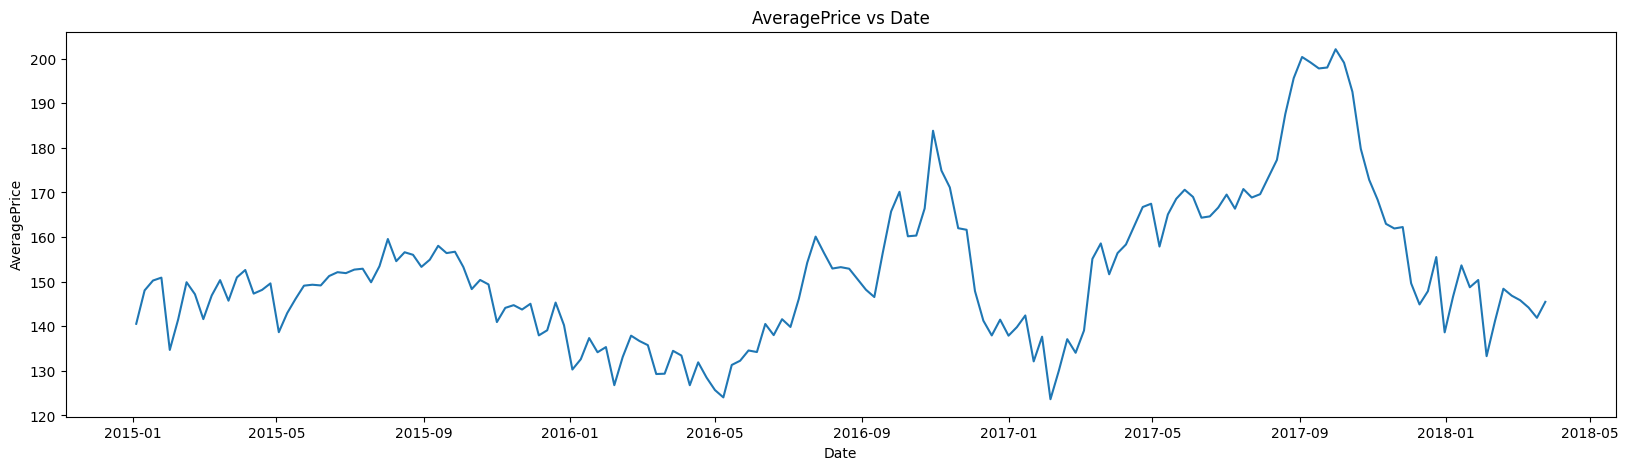

In [6]:
fig,ax = plt.subplots(nrows = 1, ncols = 2,figsize = (15,5))

plt.subplot(1,2,1)
sns.histplot(data['AveragePrice'],kde = True)
plt.title('Distribution : AveragePrice')

plt.subplot(1,2,2)
sns.histplot(df['AveragePrice'],kde=True)
plt.title('Distribution : AveragePrice')

fig,ax = plt.subplots(nrows = 1, ncols = 1,figsize = (20,5))
plt.subplot(1,1,1)
sns.lineplot(x = df.index ,y = 'AveragePrice',data = df)
plt.title('AveragePrice vs Date')

plt.show()
fig.tight_layout(pad = 2)

In [7]:
df.head()

,Unnamed: 0,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
Date,,,,,,,,,,,,,
2015-01-04,5507,140.54,84674337.20,33098258.74,36851038.43,2278818.64,12446221.39,9910008.90,2485655.90,50556.59,conventionalconventionalconventionalconvention...,217620,AlbanyAtlantaBaltimoreWashingtonBoiseBostonBuf...
2015-01-11,5399,148.03,78555807.24,31024164.99,32808429.84,2349167.45,12374044.96,10352936.42,1977832.00,43276.54,conventionalconventionalconventionalconvention...,217620,AlbanyAtlantaBaltimoreWashingtonBoiseBostonBuf...
2015-01-18,5291,150.24,78388784.08,31802706.86,31662041.93,2208250.55,12715784.74,10548854.11,2145586.13,21344.50,conventionalconventionalconventionalconvention...,217620,AlbanyAtlantaBaltimoreWashingtonBoiseBostonBuf...
2015-01-25,5183,150.89,76466281.07,32305132.87,28929122.37,2078378.86,13153646.97,10877316.95,2252815.92,23514.10,conventionalconventionalconventionalconvention...,217620,AlbanyAtlantaBaltimoreWashingtonBoiseBostonBuf...
2015-02-01,5075,134.68,119453235.25,50292988.96,50696230.48,3687489.31,14776526.50,11576833.65,3073989.39,125703.46,conventionalconventionalconventionalconvention...,217620,AlbanyAtlantaBaltimoreWashingtonBoiseBostonBuf...


In [13]:
col = list(df.columns)
categorical_features = []
numerical_features = []
for i in col:
    try:
        df[i] = pd.to_numeric(df[i])
        if df[i].dtype == int:
            categorical_features.append(i)
        numerical_features.append(i)
    except ValueError:
        categorical_features.append(i)

print('Categorical Features :',*categorical_features)
print('Numerical Features :',*numerical_features)

Categorical Features : Unnamed: 0 type year region
Numerical Features : Unnamed: 0 AveragePrice Total Volume 4046 4225 4770 Total Bags Small Bags Large Bags XLarge Bags year


In [12]:
df.head()

,Unnamed: 0,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
Date,,,,,,,,,,,,,
2015-01-04,5507,140.54,84674337.20,33098258.74,36851038.43,2278818.64,12446221.39,9910008.90,2485655.90,50556.59,conventionalconventionalconventionalconvention...,217620,AlbanyAtlantaBaltimoreWashingtonBoiseBostonBuf...
2015-01-11,5399,148.03,78555807.24,31024164.99,32808429.84,2349167.45,12374044.96,10352936.42,1977832.00,43276.54,conventionalconventionalconventionalconvention...,217620,AlbanyAtlantaBaltimoreWashingtonBoiseBostonBuf...
2015-01-18,5291,150.24,78388784.08,31802706.86,31662041.93,2208250.55,12715784.74,10548854.11,2145586.13,21344.50,conventionalconventionalconventionalconvention...,217620,AlbanyAtlantaBaltimoreWashingtonBoiseBostonBuf...
2015-01-25,5183,150.89,76466281.07,32305132.87,28929122.37,2078378.86,13153646.97,10877316.95,2252815.92,23514.10,conventionalconventionalconventionalconvention...,217620,AlbanyAtlantaBaltimoreWashingtonBoiseBostonBuf...
2015-02-01,5075,134.68,119453235.25,50292988.96,50696230.48,3687489.31,14776526.50,11576833.65,3073989.39,125703.46,conventionalconventionalconventionalconvention...,217620,AlbanyAtlantaBaltimoreWashingtonBoiseBostonBuf...
